In [1]:
## Notebook env: cell2loc_env (cell2loc_env kernel)
## this notebook performs cell2location to *spatially* deconvolute cells using a reference annotated scRNAseq dataset

In [2]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os

data_type = 'float32'

import cell2location

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

Global seed set to 0


In [3]:
results_folder = '/home/ssobti/projects/farnaz_spatial/output_data/cell2location/multi_ref_annot'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
#run_name = f'{results_folder}/cell2location_map'

In [4]:
combined_refs = anndata.read_h5ad('/home/ssobti/projects/farnaz_spatial/data/combined_and_independent_refs/combined_refs_raw_data_seurat.h5ad')

In [5]:
combined_refs.obs['cell_type_final'][combined_refs.obs['cell_type_final'] == 'Vascular_smooth muscle'] = 'Vascular_smooth_muscle'

In [6]:
datasets_to_keep = np.array(combined_refs.obs['dataset'] == 'mBAT') | np.array(combined_refs.obs['dataset'] == 'nuclear_ingWAT')

In [7]:
combined_refs = combined_refs[datasets_to_keep,]

In [8]:
combined_refs.obs

,orig.ident,nCount_RNA,nFeature_RNA,dataset,sample_name,cell_type_final,percent.mt
AAACCCAAGCAAGGAA_1,0,7437.0,1839,mBAT,4,Macrophages,0.0
AAACCCAAGCCTGCCA_1,0,2444.0,907,mBAT,4,B_cells,0.0
AAACCCAAGGGCCAAT_1,0,4746.0,1808,mBAT,4,T_cells,0.0
AAACCCACAATACAGA_1,0,7588.0,2141,mBAT,4,Macrophages,0.0
AAACCCACACAACGTT_1,0,8909.0,2605,mBAT,4,Macrophages,0.0
...,...,...,...,...,...,...,...
Mm_ING_11-1_GGTGAAGCAATACCCA,0,665.0,514,nuclear_ingWAT,42,Adipocyte_progenitors,0.0
Mm_ING_11-1_CCCGAAGAGGTGGCTA,0,600.0,479,nuclear_ingWAT,42,Adipocyte_progenitors,0.0
Mm_ING_11-1_ACTGATGAGTTCCAGT,0,545.0,409,nuclear_ingWAT,42,Adipocyte_progenitors,0.0
Mm_ING_11-1_GATAGAAAGAGTCCGA,0,475.0,346,nuclear_ingWAT,42,Adipocyte_progenitors,0.0


In [9]:
combined_refs.var

,_index,features
0,Xkr4,Xkr4
1,Sox17,Sox17
2,Mrpl15,Mrpl15
3,Lypla1,Lypla1
4,Gm37988,Gm37988
...,...,...
16603,Itih3,Itih3
16604,Defb30,Defb30
16605,Mfrp,Mfrp
16606,Gm29292,Gm29292


In [10]:
combined_refs.var.set_index('_index', drop=True, inplace=True)
combined_refs.var.index.name = None

In [11]:
combined_refs.var

,features
Xkr4,Xkr4
Sox17,Sox17
Mrpl15,Mrpl15
Lypla1,Lypla1
Gm37988,Gm37988
...,...
Itih3,Itih3
Defb30,Defb30
Mfrp,Mfrp
Gm29292,Gm29292


In [12]:
combined_refs.var['SYMBOL'] = combined_refs.var.index

# delete unnecessary raw slot (to be removed in a future version of the tutorial)
del combined_refs.raw

## Reduce number of genes (discard low expressing)

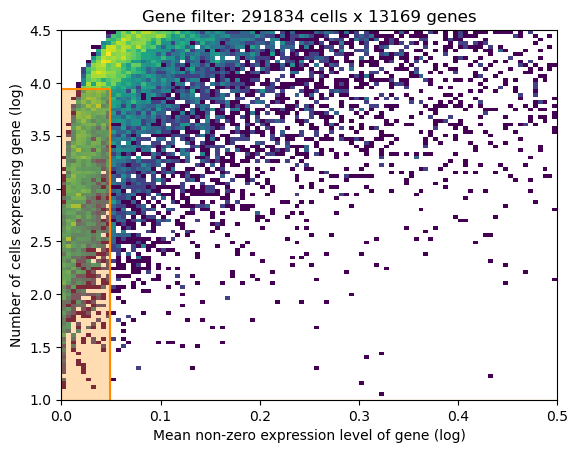

In [13]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(combined_refs, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
combined_refs = combined_refs[:, selected].copy()

In [14]:
combined_refs.obs

,orig.ident,nCount_RNA,nFeature_RNA,dataset,sample_name,cell_type_final,percent.mt
AAACCCAAGCAAGGAA_1,0,7437.0,1839,mBAT,4,Macrophages,0.0
AAACCCAAGCCTGCCA_1,0,2444.0,907,mBAT,4,B_cells,0.0
AAACCCAAGGGCCAAT_1,0,4746.0,1808,mBAT,4,T_cells,0.0
AAACCCACAATACAGA_1,0,7588.0,2141,mBAT,4,Macrophages,0.0
AAACCCACACAACGTT_1,0,8909.0,2605,mBAT,4,Macrophages,0.0
...,...,...,...,...,...,...,...
Mm_ING_11-1_GGTGAAGCAATACCCA,0,665.0,514,nuclear_ingWAT,42,Adipocyte_progenitors,0.0
Mm_ING_11-1_CCCGAAGAGGTGGCTA,0,600.0,479,nuclear_ingWAT,42,Adipocyte_progenitors,0.0
Mm_ING_11-1_ACTGATGAGTTCCAGT,0,545.0,409,nuclear_ingWAT,42,Adipocyte_progenitors,0.0
Mm_ING_11-1_GATAGAAAGAGTCCGA,0,475.0,346,nuclear_ingWAT,42,Adipocyte_progenitors,0.0


## Estimating expression signatures

In [15]:
cell2location.models.RegressionModel.setup_anndata(adata=combined_refs,
                        # 10X reaction / sample / batch
                        batch_key='dataset',
                        # cell type, covariate used for constructing signatures
                        labels_key='cell_type_final',
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        categorical_covariate_keys=None
                       )

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [16]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(combined_refs)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.0.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'dataset',
│   'labels_key': 'cell_type_final',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   2    │
│         n_cells          │ 291834 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   20   │
│          n_vars          │ 13169  │
└──────────────────────────┴────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location    ┃   Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['dataset'] │      mBAT      │          0          │
│                      │ nuclear_ingWAT │          1          │
└──────────────────────┴────────────────┴─────────────────────┘

                               labels State Registry                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃       Source Location        ┃         Categories          ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_type_final'] │    Adipocyte_progenitors    │          0          │
│                              │         Adipocytes          │          1          │
│                              │           B_cells           │          2          │
│                              │      Brown_adipocytes       │          3          │
│                              │      Endothelial_cells      │          4          │
│                              │         Eosinophils         │          5          │
│                              │      Epithelial_cells       │          6          │
│                              │ Lymphatic_endothelial_cells │          7          │
│                              │         Macrophages         │          8          │
│                              │         Mast_cells          │          9          │
│                              │         Mesothelium         │         10          │
│                              │          NK_cells           │         11          │
│                              │         Neutrophils         │         12          │
│                              │          Pericytes          │         13          │
│                              │        Schwan_cells         │         14          │
│                              │       Skeletal_muscle       │         15          │
│                              │           T_cells           │         16          │
│                              │            Tregs            │         17          │
│                              │   Vascular_smooth_muscle    │         18          │
│                              │      white adipocytes       │         19          │
└──────────────────────────────┴─────────────────────────────┴─────────────────────┘

In [17]:
## train model
mod.train(max_epochs=250, use_gpu=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 250/250: 100%|██████████| 250/250 [9:46:01<00:00, 140.44s/it, v_num=1, elbo_train=1.44e+9]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [9:46:01<00:00, 140.64s/it, v_num=1, elbo_train=1.44e+9]


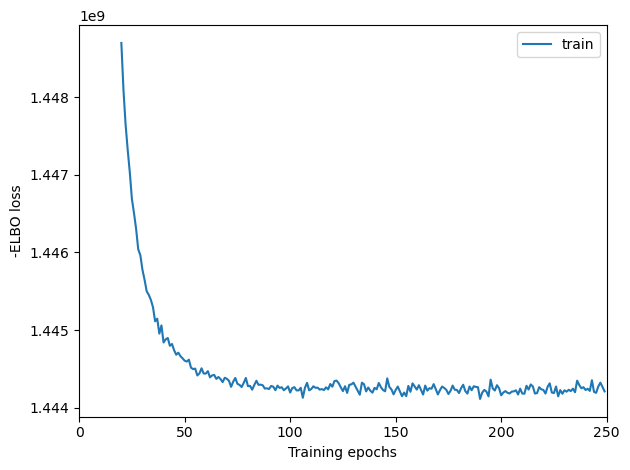

In [18]:
mod.plot_history(20)

In [19]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
combined_refs = mod.export_posterior(
    combined_refs, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': False}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
combined_refs.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [01:30<00:00, 10.99it/s]


'/home/ssobti/projects/farnaz_spatial/output_data/cell2location/multi_ref_annot/reference_signatures/sc.h5ad'

In [20]:
combined_refs = mod.export_posterior(
    combined_refs, use_quantiles=True,
    # choose quantiles
    add_to_varm=["q05","q50", "q95", "q0001"],
    sample_kwargs={'batch_size': 2500, 'use_gpu': False}
)

In [21]:
mod.plot_QC()

KeyError: 'post_sample_means'